In [1]:
%matplotlib inline
from IPython.display import clear_output

In [2]:
import pickle
import random
from collections import defaultdict
from itertools import product

import Orange
import matplotlib
from matplotlib.cm import coolwarm, Spectral_r
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import rankdata
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

from sbm_neighbour_score import sbm_neighbour_score

In [3]:
kernels_names = [
    'Katz', 'logKatz',
    'For', 'logFor',
    'Comm', 'logComm',
    'Heat', 'logHeat',
    'NHeat', 'logNHeat',
    'SCT', 'SCCT',
    'RSP', 'FE',
    'PPR', 'logPPR',
    'ModifPPR', 'logModifPPR',
    'HeatPR', 'logHeatPR',
    'DF', 'logDF',
    'Abs', 'logAbs',
    'SP-CT'
]

shuffle = lambda x: sorted(x, key=lambda k: random.random())

def dict_argmax(dct, score_key):
    best_key = list(dct.keys())[0]
    best_val = dct[best_key]
    for k, v in dct.items():
        if v[score_key] > best_val[score_key]:
            best_key, best_val = k, v
    return best_key, best_val

CACHE_ROOT = '../../cache/cache'

def calc_avranks(results):  # {dataset: {classifier: accuracy}}
    ranks = defaultdict(list)
    for dataset, classifier_accuracy in results.items():
        if type(dataset) == tuple:
            dataset = '_'.join([str(x) for x in dataset])
        classifiers, accuracies = zip(*list(classifier_accuracy.items()))
        for classifier, rank in zip(classifiers, rankdata(accuracies)):
            ranks[classifier].append(rank)
    ranks = {k: np.mean(v) for k, v in sorted(ranks.items(), key=lambda x: x[0])}
    return list(ranks.values()), list(ranks.keys()), len(results)

# Analyze results of SBM – Stochastic Block Model

In [4]:
SBM_RESULTS_ROOT = '../../cache/kkmeans_init_sbm'
columns = [
    (100, 2, 0.05, 0.001), (100, 2, 0.05, 0.002), (100, 2, 0.05, 0.005), (100, 2, 0.05, 0.007),
    (100, 2, 0.05, 0.01), (100, 2, 0.05, 0.02), (100, 2, 0.05, 0.03), (100, 2, 0.05, 0.05),
    
    (100, 2, 0.1, 0.001), (100, 2, 0.1, 0.002), (100, 2, 0.1, 0.005), (100, 2, 0.1, 0.01),
    (100, 2, 0.1, 0.02), (100, 2, 0.1, 0.03), (100, 2, 0.1, 0.05), (100, 2, 0.1, 0.07),
    (100, 2, 0.1, 0.1),
    
    (100, 2, 0.15, 0.01), (100, 2, 0.15, 0.03), (100, 2, 0.15, 0.05), (100, 2, 0.15, 0.07),
    (100, 2, 0.15, 0.1), (100, 2, 0.15, 0.15),
    
    (100, 2, 0.2, 0.05), (100, 2, 0.2, 0.1), (100, 2, 0.2, 0.15),
    
    (100, 2, 0.3, 0.05), (100, 2, 0.3, 0.1), (100, 2, 0.3, 0.15),
    
    (102, 3, 0.1, 0.001), (102, 3, 0.1, 0.005), (102, 3, 0.1, 0.01), (102, 3, 0.1, 0.02),
    (102, 3, 0.1, 0.05), (102, 3, 0.1, 0.1),
    
    (102, 3, 0.3, 0.05), (102, 3, 0.3, 0.1), (102, 3, 0.3, 0.15),
    
    (100, 4, 0.1, 0.001), (100, 4, 0.1, 0.005), (100, 4, 0.1, 0.01), (100, 4, 0.1, 0.02),
    (100, 4, 0.1, 0.05), (100, 4, 0.1, 0.1),
   
    (100, 4, 0.3, 0.1), (100, 4, 0.3, 0.15),
    
    (150, 3, 0.1, 0.001), (150, 3, 0.1, 0.005), (150, 3, 0.1, 0.01), (150, 3, 0.1, 0.02),
    (150, 3, 0.1, 0.05), (150, 3, 0.1, 0.1),
    
    (200, 2, 0.3, 0.05), (200, 2, 0.3, 0.1), (200, 2, 0.3, 0.15),
    
    (201, 3, 0.3, 0.1),
    
    (200, 4, 0.3, 0.1), (200, 4, 0.3, 0.15)
]

def column2str(column):
    n, k, p_in, p_out = column
    return f'{n}_{k}_{p_in:.2f}_{p_out:.3f}'

datasets = [column2str(x) for x in columns]

In [5]:
with open(f'{CACHE_ROOT}/sbm_inits_bestparam_byari_individual.pkl', 'rb') as f:
    results = pickle.load(f)  # {(dataset, kernel_name, graph_idx): {scorename_initname: best_ari}}
with open(f'{CACHE_ROOT}/sbm_modularity.pkl', 'rb') as f:
    modularity_results = pickle.load(f)  # {(dataset, graph_idx): modularity}
    
for key in list(results.keys()):
    if key[0] not in datasets:
        del results[key]
        
for key in list(results.keys()):
    if key[0] not in datasets:
        del modularity_results[key]

In [6]:
# table for modularity any3
results_m3_dka = defaultdict(lambda: defaultdict(list)) # {dataset, {kernel_name: [best_ari_for_graph]}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_m3_dka[dataset][kernel_name].append(si_ari['modularity_any3'])
for dataset, kernel_name in product(datasets, kernels_names):  # {dataset, {kernel_name: mean_bestari}}
    results_m3_dka[dataset][kernel_name] = np.mean(results_m3_dka[dataset][kernel_name])

dataset_meanari = {k: np.mean(list(v.values())) for k, v in results_m3_dka.items()}  # {dataset, mean_mean_bestari}
for dataset, meanari in sorted(list(dataset_meanari.items()), key=lambda x: x[1]):
    print(f'{dataset}: {meanari:.2f}')

150_3_0.10_0.100: 0.04
100_4_0.10_0.100: 0.04
100_2_0.05_0.050: 0.04
102_3_0.10_0.100: 0.05
100_2_0.15_0.150: 0.05
100_2_0.10_0.100: 0.05
100_4_0.10_0.050: 0.08
100_2_0.05_0.030: 0.10
100_2_0.10_0.070: 0.10
102_3_0.10_0.050: 0.12
150_3_0.10_0.050: 0.12
100_2_0.20_0.150: 0.13
100_2_0.15_0.100: 0.15
100_2_0.05_0.020: 0.16
100_2_0.10_0.050: 0.22
100_4_0.30_0.150: 0.22
100_4_0.10_0.020: 0.28
200_4_0.30_0.150: 0.36
102_3_0.30_0.150: 0.38
100_2_0.15_0.070: 0.40
102_3_0.10_0.020: 0.45
100_2_0.05_0.010: 0.45
100_4_0.30_0.100: 0.52
100_2_0.20_0.100: 0.53
100_4_0.10_0.010: 0.55
100_2_0.05_0.007: 0.59
100_2_0.10_0.030: 0.59
150_3_0.10_0.020: 0.64
100_2_0.05_0.005: 0.72
100_4_0.10_0.005: 0.74
100_2_0.15_0.050: 0.74
102_3_0.10_0.010: 0.75
100_2_0.30_0.150: 0.76
102_3_0.30_0.100: 0.78
200_4_0.30_0.100: 0.80
100_2_0.10_0.020: 0.82
200_2_0.30_0.150: 0.86
201_3_0.30_0.100: 0.88
150_3_0.10_0.010: 0.89
102_3_0.10_0.005: 0.90
100_2_0.05_0.002: 0.90
100_4_0.10_0.001: 0.92
100_2_0.15_0.030: 0.93
100_2_0.30_

In [7]:
df = pd.DataFrame({k: {'ari': v} for k, v in dataset_meanari.items()}).transpose()
df['column'] = df.index.str.split('_').tolist()
df['n'] = df['column'].apply(lambda x: int(x[0]))
df['k'] = df['column'].apply(lambda x: int(x[1]))
df['p_in'] = df['column'].apply(lambda x: float(x[2]))
df['p_out'] = df['column'].apply(lambda x: float(x[3]))
df['p_in/p_out'] = df[['p_in', 'p_out']].apply(lambda x: x['p_in']/x['p_out'], axis=1)
df

,ari,column,n,k,p_in,p_out,p_in/p_out
100_2_0.05_0.001,0.943365,"[100, 2, 0.05, 0.001]",100,2,0.05,0.001,50.000000
100_2_0.05_0.002,0.902240,"[100, 2, 0.05, 0.002]",100,2,0.05,0.002,25.000000
100_2_0.05_0.005,0.717464,"[100, 2, 0.05, 0.005]",100,2,0.05,0.005,10.000000
100_2_0.05_0.007,0.585785,"[100, 2, 0.05, 0.007]",100,2,0.05,0.007,7.142857
100_2_0.05_0.010,0.448016,"[100, 2, 0.05, 0.010]",100,2,0.05,0.010,5.000000
100_2_0.05_0.020,0.157519,"[100, 2, 0.05, 0.020]",100,2,0.05,0.020,2.500000
100_2_0.05_0.030,0.097034,"[100, 2, 0.05, 0.030]",100,2,0.05,0.030,1.666667
100_2_0.05_0.050,0.041954,"[100, 2, 0.05, 0.050]",100,2,0.05,0.050,1.000000
100_2_0.10_0.001,0.994389,"[100, 2, 0.10, 0.001]",100,2,0.10,0.001,100.000000
100_2_0.10_0.002,0.991592,"[100, 2, 0.10, 0.002]",100,2,0.10,0.002,50.000000


In [8]:
dataset_modularity = dict()
for dataset in datasets:
    dataset_modularity[dataset] = np.mean([modularity_results[(dataset, graph_idx)] for graph_idx in range(100)])
for dataset, modularity in sorted(list(dataset_modularity.items()), key=lambda x: x[1]):
    print(f'{dataset}: {modularity:.2f}')

100_4_0.10_0.100: -0.01
102_3_0.10_0.100: -0.01
100_2_0.05_0.050: -0.01
150_3_0.10_0.100: -0.01
100_2_0.15_0.150: -0.01
100_2_0.10_0.100: -0.01
100_2_0.20_0.150: 0.07
100_2_0.10_0.070: 0.09
100_2_0.15_0.100: 0.09
100_2_0.05_0.030: 0.12
100_4_0.10_0.050: 0.14
100_4_0.30_0.150: 0.14
200_4_0.30_0.150: 0.14
102_3_0.10_0.050: 0.16
150_3_0.10_0.050: 0.16
102_3_0.30_0.150: 0.16
100_2_0.20_0.100: 0.16
100_2_0.30_0.150: 0.16
100_2_0.10_0.050: 0.16
200_2_0.30_0.150: 0.16
100_2_0.15_0.070: 0.17
100_2_0.05_0.020: 0.21
100_4_0.30_0.100: 0.24
200_4_0.30_0.100: 0.25
100_2_0.30_0.100: 0.25
100_2_0.15_0.050: 0.25
200_2_0.30_0.100: 0.25
102_3_0.30_0.100: 0.26
201_3_0.30_0.100: 0.26
100_2_0.10_0.030: 0.27
100_2_0.20_0.050: 0.29
100_2_0.15_0.030: 0.33
100_2_0.05_0.010: 0.33
100_2_0.10_0.020: 0.33
100_2_0.30_0.050: 0.35
200_2_0.30_0.050: 0.36
100_4_0.10_0.020: 0.37
102_3_0.10_0.020: 0.37
100_2_0.05_0.007: 0.37
150_3_0.10_0.020: 0.37
100_2_0.05_0.005: 0.40
100_2_0.10_0.010: 0.41
102_3_0.30_0.050: 0.41
100_2

## CD diagram

n_experiments: 145000


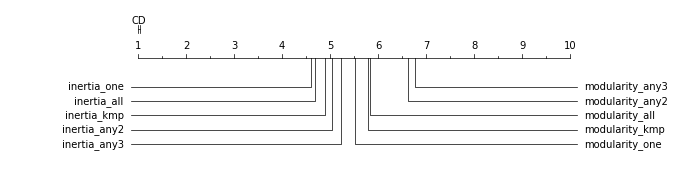

In [9]:
avranks, names, n_experiments = calc_avranks(results)
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments)
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

n_experiments: 5800


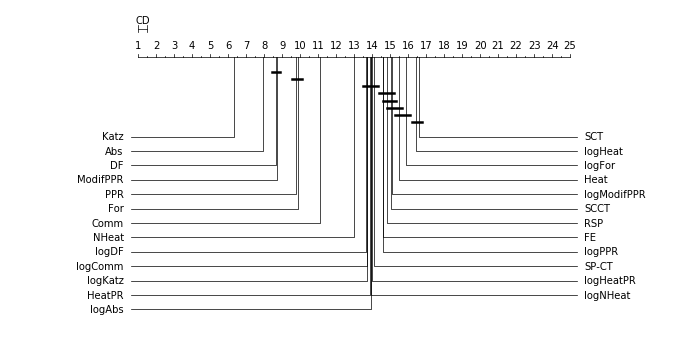

In [10]:
results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {dataset_graphidx, {kernel_name: best_ari}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

avranks, names, n_experiments = calc_avranks(results_modularity_any3)
print(f'n_experiments: {n_experiments}')
cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
plt.show()

## Group datasets by measure ranking

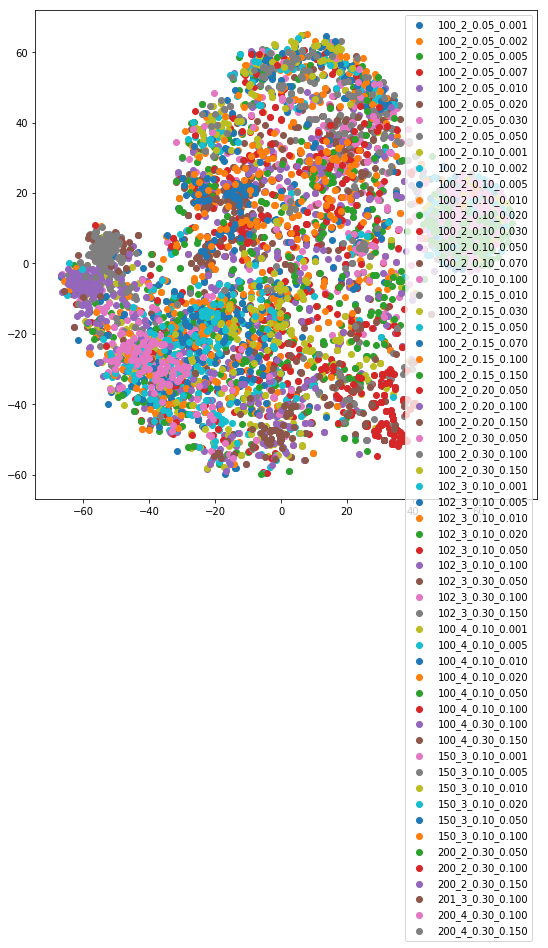

In [11]:
results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {(dataset, graph_idx), {kernel_name: best_ari}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

dataset_graphidx_avranks = dict()
for dataset_name, dataset_results in results_modularity_any3.items():
    avranks, _, _ = calc_avranks({'0': dataset_results})
    dataset_graphidx_avranks[dataset_name] = avranks
    
# TSNE
X_embedded = TSNE(n_components=2, learning_rate=200).fit_transform(list(dataset_graphidx_avranks.values()))

dataset_embedding = defaultdict(list)  # {dataset: [embedding]}
for (dataset, graph_idx), X_embedded_item in zip(list(dataset_graphidx_avranks.keys()), X_embedded):
    dataset_embedding[dataset].append(X_embedded_item)
    
plt.subplots(1, figsize=(9, 9))
for dataset, embedding in dataset_embedding.items():
    embedding = np.array(embedding)
    plt.scatter(embedding[:, 0], embedding[:, 1], label=dataset)
plt.legend()

In [12]:
results_modularity_any3 = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))  # {dataset: {graphidx: {kernel_name: best_ari}}}
for (dataset, kernel_name, graph_idx), si_ari in results.items():
    results_modularity_any3[dataset][graph_idx][kernel_name] = si_ari['modularity_any3']

dataset_avranks = dict()  # {dataset: avranks}
for dataset_name, dataset_results in results_modularity_any3.items():
    avranks, _, _ = calc_avranks(dataset_results)
    dataset_avranks[dataset_name] = avranks

n_clusters = 4
# kmeans = KMeans(n_clusters=n_clusters)
kmeans = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
kmeans.fit(list(dataset_avranks.values()))

datasets_partition = []  # [[dataset]]
for class_idx in range(n_clusters):
    datasetss = [dataset_name for dataset_name, label in zip(list(dataset_avranks.keys()), kmeans.labels_) if label == class_idx]
    datasets_partition.append(datasetss)
    
datasets_partition_mari = []
for partition in datasets_partition:
    datasets_partition_mari.append(np.mean([dataset_meanari[dataset] for dataset in partition]))

partition_order = [int(x)-1 for x in rankdata(datasets_partition_mari)]
datasets_partition = [datasets_partition[x] for x in partition_order]
datasets_partition_mari = [datasets_partition_mari[x] for x in partition_order]

for i in range(n_clusters):
    print(f'Partition {i}, mari={datasets_partition_mari[i]:.2f}')
    print(f'  {", ".join(["(" + ", ".join(x.split("_")) + ")" for x in datasets_partition[i]])}')

Partition 0, mari=0.10
  (100, 2, 0.05, 0.020), (100, 2, 0.05, 0.030), (100, 2, 0.05, 0.050), (100, 2, 0.10, 0.050), (100, 2, 0.10, 0.070), (100, 2, 0.10, 0.100), (100, 2, 0.15, 0.100), (100, 2, 0.15, 0.150), (100, 2, 0.20, 0.150), (102, 3, 0.10, 0.050), (102, 3, 0.10, 0.100), (100, 4, 0.10, 0.050), (100, 4, 0.10, 0.100), (100, 4, 0.30, 0.150), (150, 3, 0.10, 0.050), (150, 3, 0.10, 0.100)
Partition 1, mari=0.90
  (100, 2, 0.05, 0.001), (100, 2, 0.05, 0.002), (100, 2, 0.05, 0.005), (100, 2, 0.05, 0.007), (100, 2, 0.05, 0.010), (100, 2, 0.10, 0.001), (100, 2, 0.10, 0.002), (100, 2, 0.10, 0.005), (100, 2, 0.10, 0.010), (100, 2, 0.15, 0.010), (100, 2, 0.30, 0.050), (102, 3, 0.10, 0.001), (102, 3, 0.10, 0.005), (100, 4, 0.10, 0.001), (150, 3, 0.10, 0.001), (150, 3, 0.10, 0.005), (200, 2, 0.30, 0.050)
Partition 2, mari=0.42
  (102, 3, 0.30, 0.150), (100, 4, 0.30, 0.100), (200, 4, 0.30, 0.150)
Partition 3, mari=0.73
  (100, 2, 0.10, 0.020), (100, 2, 0.10, 0.030), (100, 2, 0.15, 0.030), (100, 

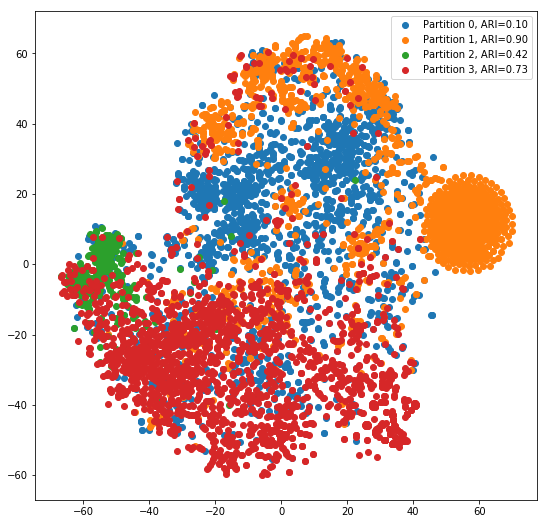

In [13]:
plt.subplots(1, figsize=(9, 9))
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    embedding_filtered = []
    for dataset in datasetss:
        embedding_filtered.extend(dataset_embedding[dataset])
    embedding_filtered = np.array(embedding_filtered)
    plt.scatter(embedding_filtered[:, 0], embedding_filtered[:, 1], label=f'Partition {class_idx}, ARI={datasets_partition_mari[class_idx]:.2f}')
plt.legend()

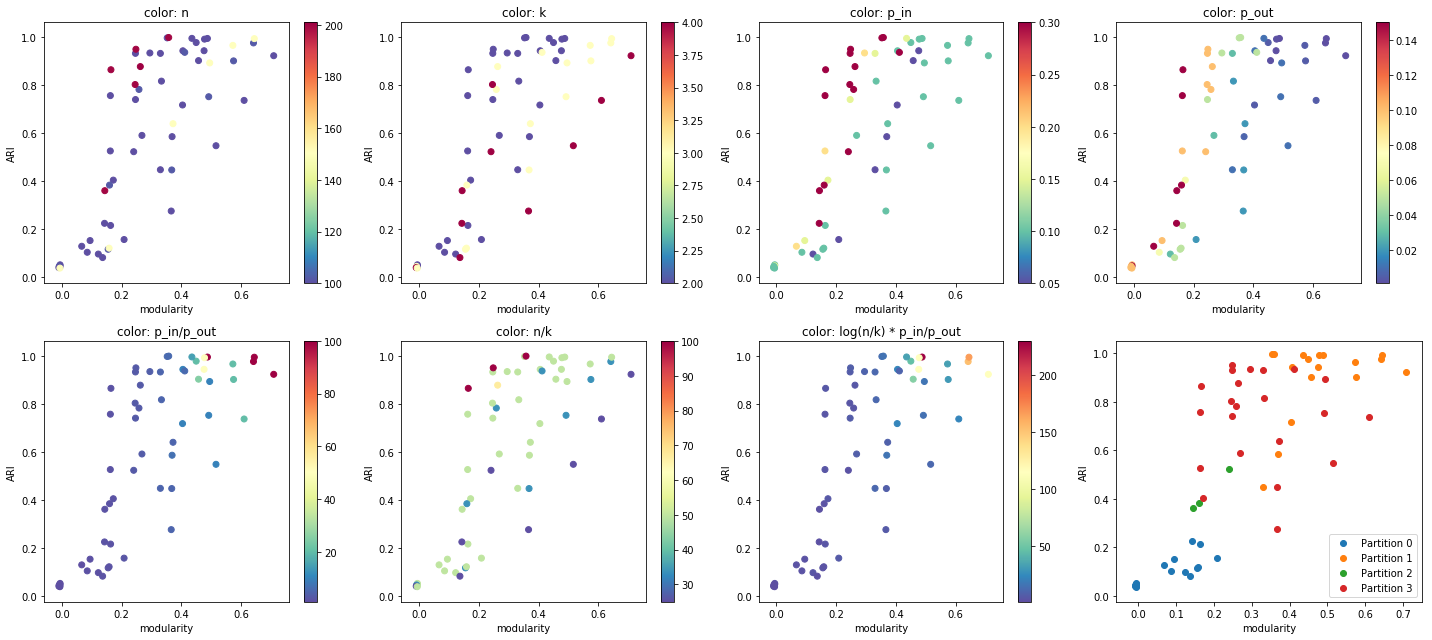

In [14]:
def extract_feature(dataset_name, feature):
    n, k, p_in, p_out = [float(x) for x in dataset_name.split('_')]
    if feature == 'n':
        return n
    elif feature == 'k':
        return k
    elif feature == 'p_in':
        return p_in
    elif feature == 'p_out':
        return p_out
    elif feature == 'p_in/p_out':
        return p_in / p_out
    elif feature == 'n/k':
        return n / k
    elif feature == 'n/k * p_in/p_out':
        return (n / k) * (p_in / p_out)
    elif feature == 'log(n/k) * p_in/p_out':
        return np.log(n) / k * (p_in / p_out)
    elif feature == 'sbm_neighbour_score':
        return sbm_neighbour_score(int(n), int(k), p_in, p_out)
    elif feature == 'class_idx':
        for class_idx, datasetss in enumerate(datasets_partition):
            if dataset_name in datasetss:
                return class_idx
        return -1

# draw ari-modularity dependency
fig, ax = plt.subplots(2, 4, figsize=(20, 9))
ax = np.ravel(ax)

for idx, feature in enumerate(['n', 'k', 'p_in', 'p_out', 'p_in/p_out', 'n/k', 'log(n/k) * p_in/p_out']):
    x, y, v = [], [], []
    for dataset in datasets:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
        v.append(extract_feature(dataset, feature))
    sc = ax[idx].scatter(x, y, c=v, cmap='Spectral_r')
    ax[idx].set_xlabel('modularity')
    ax[idx].set_ylabel('ARI')
    ax[idx].set_title('color: ' + feature)
    plt.colorbar(sc, ax=ax[idx])
    
idx = 7
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('modularity')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

plt.tight_layout()

In [15]:
datasets_by_groups = defaultdict(dict)
for dataset in datasets:
    n, k, p_in, p_out = dataset.split('_')
    n, k, p_in, p_out = int(n), int(k), float(p_in), float(p_out)
    n_normalized = n // 10 * 10
    
    group = '_'.join([str(x) for x in (n, k, p_in)])
    datasets_by_groups[group][(n_normalized, k, p_in, p_out)] = dataset

for group, datasetss in datasets_by_groups.items():
    print(f'{group}: {datasetss}')

100_2_0.05: {(100, 2, 0.05, 0.001): '100_2_0.05_0.001', (100, 2, 0.05, 0.002): '100_2_0.05_0.002', (100, 2, 0.05, 0.005): '100_2_0.05_0.005', (100, 2, 0.05, 0.007): '100_2_0.05_0.007', (100, 2, 0.05, 0.01): '100_2_0.05_0.010', (100, 2, 0.05, 0.02): '100_2_0.05_0.020', (100, 2, 0.05, 0.03): '100_2_0.05_0.030', (100, 2, 0.05, 0.05): '100_2_0.05_0.050'}
100_2_0.1: {(100, 2, 0.1, 0.001): '100_2_0.10_0.001', (100, 2, 0.1, 0.002): '100_2_0.10_0.002', (100, 2, 0.1, 0.005): '100_2_0.10_0.005', (100, 2, 0.1, 0.01): '100_2_0.10_0.010', (100, 2, 0.1, 0.02): '100_2_0.10_0.020', (100, 2, 0.1, 0.03): '100_2_0.10_0.030', (100, 2, 0.1, 0.05): '100_2_0.10_0.050', (100, 2, 0.1, 0.07): '100_2_0.10_0.070', (100, 2, 0.1, 0.1): '100_2_0.10_0.100'}
100_2_0.15: {(100, 2, 0.15, 0.01): '100_2_0.15_0.010', (100, 2, 0.15, 0.03): '100_2_0.15_0.030', (100, 2, 0.15, 0.05): '100_2_0.15_0.050', (100, 2, 0.15, 0.07): '100_2_0.15_0.070', (100, 2, 0.15, 0.1): '100_2_0.15_0.100', (100, 2, 0.15, 0.15): '100_2_0.15_0.150'}


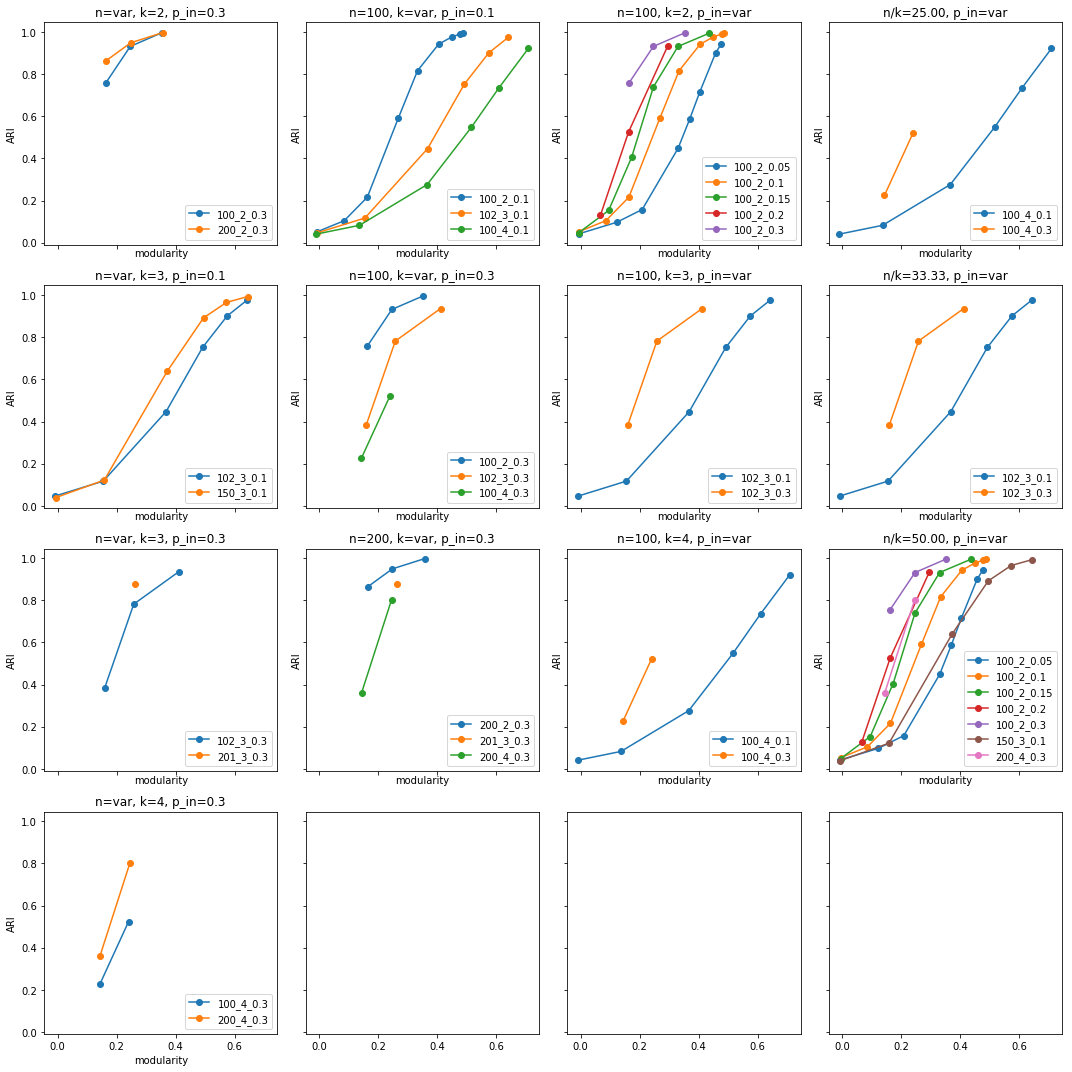

In [37]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

# варьируем n при фиксированных k, p_in
idx = 0
for k, p_in in sorted(list(set([(int(group.split('_')[1]), float(group.split('_')[2])) for group, datasetss in datasets_by_groups.items()]))):

    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dk == k and dp_in == p_in]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(dataset_modularity[dataset])
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][0]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('modularity')
        axi.set_ylabel('ARI')
        axi.set_title(f'n=var, k={k}, p_in={p_in}')
        axi.legend(loc=4)
        idx += 1
    
# варьируем k при фиксированных n, p_in
idx = 0
for n, p_in in sorted(list(set([(int(group.split('_')[0]) // 10 * 10, float(group.split('_')[2])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dn == n and dp_in == p_in]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(dataset_modularity[dataset])
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][1]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('modularity')
        axi.set_ylabel('ARI')
        axi.set_title(f'n={n}, k=var, p_in={p_in}')
        axi.legend(loc=4)
        idx += 1

# варьируем p_in при фиксированных n, k
idx = 0
for n, k in sorted(list(set([(int(group.split('_')[0]) // 10 * 10, int(group.split('_')[1])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dn == n and dk == k]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(dataset_modularity[dataset])
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))

    if len(datasets_to_plot) > 1:
        axi = ax[idx][2]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('modularity')
        axi.set_ylabel('ARI')
        axi.set_title(f'n={n}, k={k}, p_in=var')
        axi.legend(loc=4)
        idx += 1
        
# варьируем p_in при фиксированных n/k
idx = 0
for n_k in [100/4, 100/3, 100/2, 100.]:
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dn/dk == n_k]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(dataset_modularity[dataset])
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))

    if len(datasets_to_plot) > 1:
        axi = ax[idx][3]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('modularity')
        axi.set_ylabel('ARI')
        axi.set_title(f'n/k={n_k:.2f}, p_in=var')
        axi.legend(loc=4)
        idx += 1
        
plt.tight_layout()

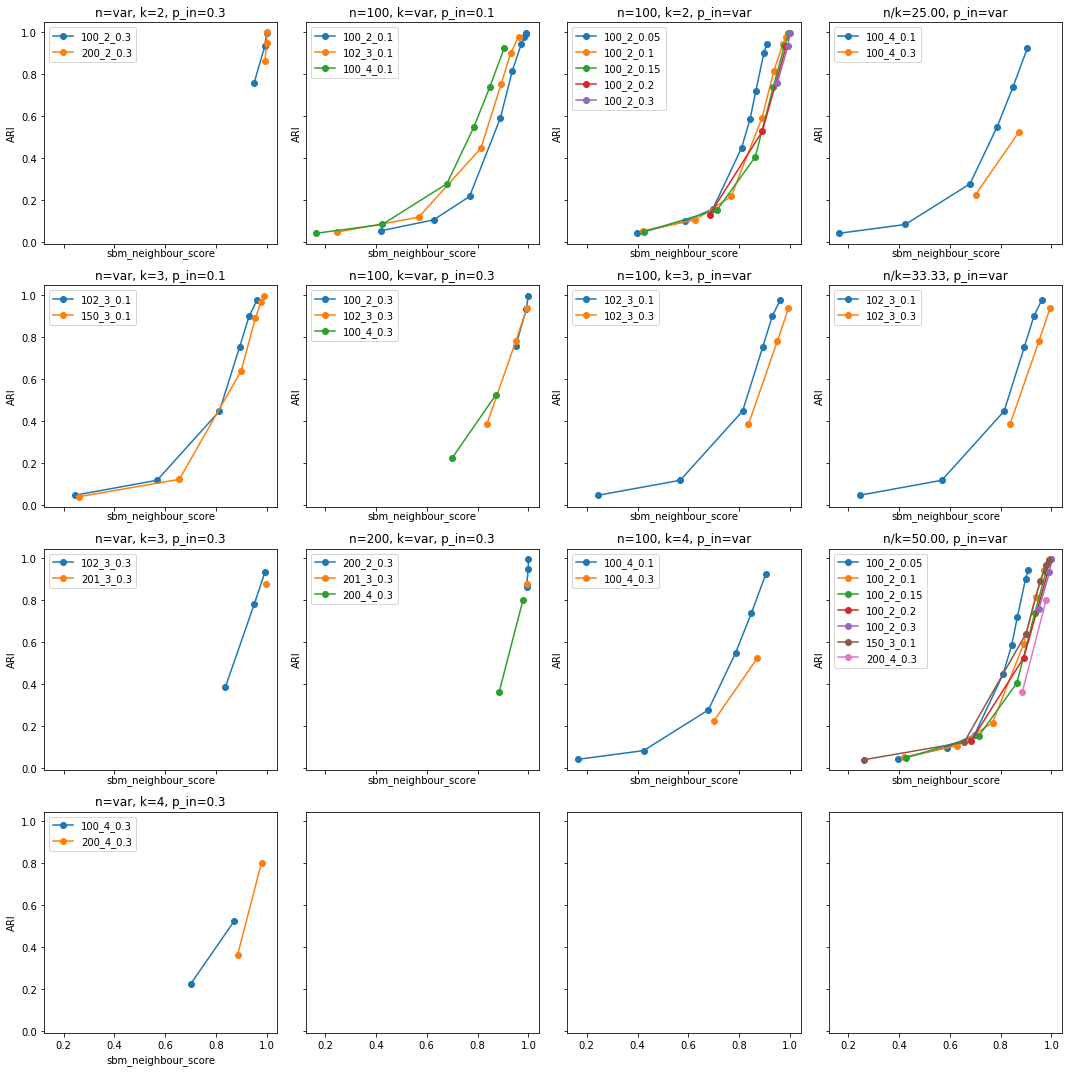

In [36]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)

# варьируем n при фиксированных k, p_in
idx = 0
for k, p_in in sorted(list(set([(int(group.split('_')[1]), float(group.split('_')[2])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dk == k and dp_in == p_in]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(extract_feature(dataset, 'sbm_neighbour_score'))
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][0]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('sbm_neighbour_score')
        axi.set_ylabel('ARI')
        axi.set_title(f'n=var, k={k}, p_in={p_in}')
        axi.legend(loc=2)
        plt.tight_layout()
        idx += 1
    
    
# варьируем k при фиксированных n, p_in
idx = 0
for n, p_in in sorted(list(set([(int(group.split('_')[0]) // 10 * 10, float(group.split('_')[2])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dn == n and dp_in == p_in]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(extract_feature(dataset, 'sbm_neighbour_score'))
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][1]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('sbm_neighbour_score')
        axi.set_ylabel('ARI')
        axi.set_title(f'n={n}, k=var, p_in={p_in}')
        axi.legend(loc=2)
        plt.tight_layout()
        idx += 1

# варьируем p_in при фиксированных n, k
idx = 0
for n, k in sorted(list(set([(int(group.split('_')[0]) // 10 * 10, int(group.split('_')[1])) for group, datasetss in datasets_by_groups.items()]))):
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dn == n and dk == k]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(extract_feature(dataset, 'sbm_neighbour_score'))
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][2]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('sbm_neighbour_score')
        axi.set_ylabel('ARI')
        axi.set_title(f'n={n}, k={k}, p_in=var')
        axi.legend(loc=2)
        plt.tight_layout()
        idx += 1
        
# варьируем p_in при фиксированном n/k
idx = 0
for n_k in [100/4, 100/3, 100/2, 100.]:
    datasets_to_plot = []
    for group, datasetss in datasets_by_groups.items():
        datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dn/dk == n_k]
        if len(datasetss) > 0:
            x, y = [], []
            for dataset in datasetss:
                x.append(extract_feature(dataset, 'sbm_neighbour_score'))
                y.append(dataset_meanari[dataset])
            datasets_to_plot.append((np.array(x), np.array(y), group))
            
    if len(datasets_to_plot) > 1:
        axi = ax[idx][3]
        for x, y, label in datasets_to_plot:
            axi.plot(x, y, '-o', label=label)
        axi.set_xlabel('sbm_neighbour_score')
        axi.set_ylabel('ARI')
        axi.set_title(f'n/k={n_k:.2f}, p_in=var')
        axi.legend(loc=2)
        plt.tight_layout()
        idx += 1

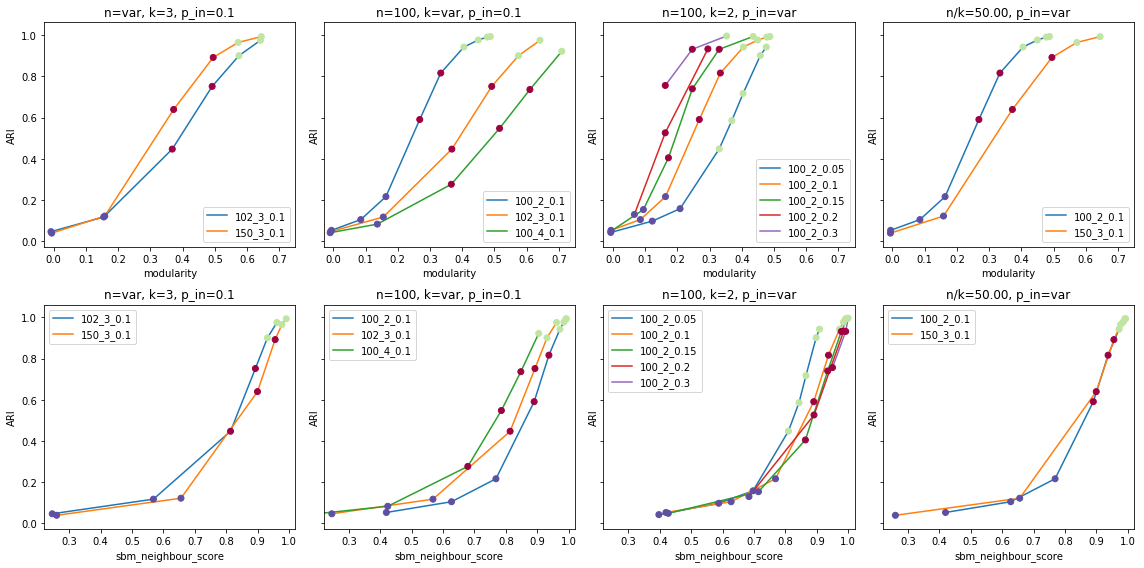

In [18]:
fig, ax = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

mod_xlim = -.03, .75
sns_xlim = 0.22, 1.02

# варьируем n при фиксированных k, p_in
k, p_in = 3, 0.1
datasets_to_plot = []
for group, datasetss in datasets_by_groups.items():
    datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dk == k and dp_in == p_in]
    if len(datasetss) > 0:
        mod, ari, sns, cls_ = [], [], [], []
        for dataset in datasetss:
            mod.append(dataset_modularity[dataset])
            sns.append(extract_feature(dataset, 'sbm_neighbour_score'))
            ari.append(dataset_meanari[dataset])
            cls_.append(extract_feature(dataset, 'class_idx'))
        datasets_to_plot.append((np.array(mod), np.array(sns), np.array(ari), np.array(cls_), group))

axi = ax[0][0]
for x, _, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('modularity')
axi.set_ylabel('ARI')
axi.set_title(f'n=var, k={k}, p_in={p_in}')
axi.legend(loc=4)
axi.set_xlim(*mod_xlim)

axi = ax[1][0]
for _, x, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('sbm_neighbour_score')
axi.set_ylabel('ARI')
axi.set_title(f'n=var, k={k}, p_in={p_in}')
axi.legend(loc=2)
axi.set_xlim(*sns_xlim)


# варьируем k при фиксированных n, p_in
n, p_in = 100, 0.1
datasets_to_plot = []
for group, datasetss in datasets_by_groups.items():
    datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dn == n and dp_in == p_in]
    if len(datasetss) > 0:
        mod, ari, sns, cls_ = [], [], [], []
        for dataset in datasetss:
            mod.append(dataset_modularity[dataset])
            sns.append(extract_feature(dataset, 'sbm_neighbour_score'))
            ari.append(dataset_meanari[dataset])
            cls_.append(extract_feature(dataset, 'class_idx'))
        datasets_to_plot.append((np.array(mod), np.array(sns), np.array(ari), np.array(cls_), group))

axi = ax[0][1]
for x, _, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('modularity')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k=var, p_in={p_in}')
axi.legend(loc=4)
axi.set_xlim(*mod_xlim)

axi = ax[1][1]
for _, x, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('sbm_neighbour_score')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k=var, p_in={p_in}')
axi.legend(loc=2)
axi.set_xlim(*sns_xlim)


# варьируем p_in при фиксированных n, k
n, k = 100, 2
datasets_to_plot = []
for group, datasetss in datasets_by_groups.items():
    datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dn == n and dk == k]
    if len(datasetss) > 0:
        mod, ari, sns, cls_ = [], [], [], []
        for dataset in datasetss:
            mod.append(dataset_modularity[dataset])
            sns.append(extract_feature(dataset, 'sbm_neighbour_score'))
            ari.append(dataset_meanari[dataset])
            cls_.append(extract_feature(dataset, 'class_idx'))
        datasets_to_plot.append((np.array(mod), np.array(sns), np.array(ari), np.array(cls_), group))

axi = ax[0][2]
for x, _, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('modularity')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k={k}, p_in=var')
axi.legend(loc=4)
axi.set_xlim(*mod_xlim)

axi = ax[1][2]
for _, x, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('sbm_neighbour_score')
axi.set_ylabel('ARI')
axi.set_title(f'n={n}, k={k}, p_in=var')
axi.legend(loc=2)
axi.set_xlim(*sns_xlim)


# варьируем p_in при фиксированных n/k
n_k, p_in = 100/2, 0.1
datasets_to_plot = []
for group, datasetss in datasets_by_groups.items():
    datasetss = [val for (dn, dk, dp_in, _), val in sorted(datasetss.items(), key=lambda x: x[0], reverse=True) if dn/dk == n_k and dp_in == p_in]
    if len(datasetss) > 0:
        mod, ari, sns, cls_ = [], [], [], []
        for dataset in datasetss:
            mod.append(dataset_modularity[dataset])
            sns.append(extract_feature(dataset, 'sbm_neighbour_score'))
            ari.append(dataset_meanari[dataset])
            cls_.append(extract_feature(dataset, 'class_idx'))
        datasets_to_plot.append((np.array(mod), np.array(sns), np.array(ari), np.array(cls_), group))

axi = ax[0][3]
for x, _, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('modularity')
axi.set_ylabel('ARI')
axi.set_title(f'n/k={n_k:.2f}, p_in=var')
axi.legend(loc=4)
axi.set_xlim(*mod_xlim)

axi = ax[1][3]
for _, x, y, cls_, label in datasets_to_plot:
    axi.plot(x, y, '-', label=label, zorder=1)
    axi.scatter(x, y, c=cls_, cmap='Spectral_r', zorder=2, vmin=0, vmax=3)
axi.set_xlabel('sbm_neighbour_score')
axi.set_ylabel('ARI')
axi.set_title(f'n/k={n_k:.2f}, p_in=var')
axi.legend(loc=2)
axi.set_xlim(*sns_xlim)


plt.tight_layout()

Partition 0, mari=0.10, n_experiments: 1600
  (100, 2, 0.05, 0.020), (100, 2, 0.05, 0.030), (100, 2, 0.05, 0.050), (100, 2, 0.10, 0.050), (100, 2, 0.10, 0.070), (100, 2, 0.10, 0.100), (100, 2, 0.15, 0.100), (100, 2, 0.15, 0.150), (100, 2, 0.20, 0.150), (102, 3, 0.10, 0.050), (102, 3, 0.10, 0.100), (100, 4, 0.10, 0.050), (100, 4, 0.10, 0.100), (100, 4, 0.30, 0.150), (150, 3, 0.10, 0.050), (150, 3, 0.10, 0.100)


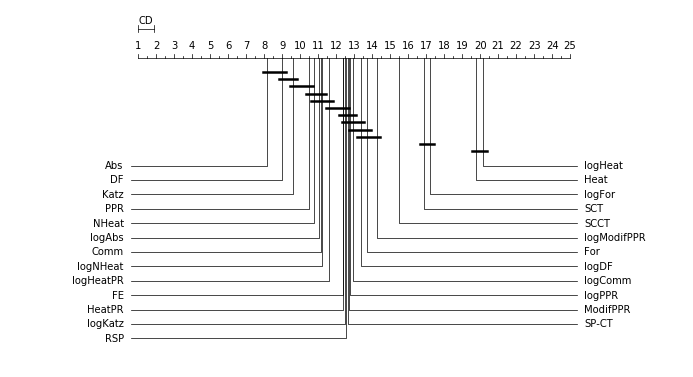

Partition 1, mari=0.90, n_experiments: 1700
  (100, 2, 0.05, 0.001), (100, 2, 0.05, 0.002), (100, 2, 0.05, 0.005), (100, 2, 0.05, 0.007), (100, 2, 0.05, 0.010), (100, 2, 0.10, 0.001), (100, 2, 0.10, 0.002), (100, 2, 0.10, 0.005), (100, 2, 0.10, 0.010), (100, 2, 0.15, 0.010), (100, 2, 0.30, 0.050), (102, 3, 0.10, 0.001), (102, 3, 0.10, 0.005), (100, 4, 0.10, 0.001), (150, 3, 0.10, 0.001), (150, 3, 0.10, 0.005), (200, 2, 0.30, 0.050)


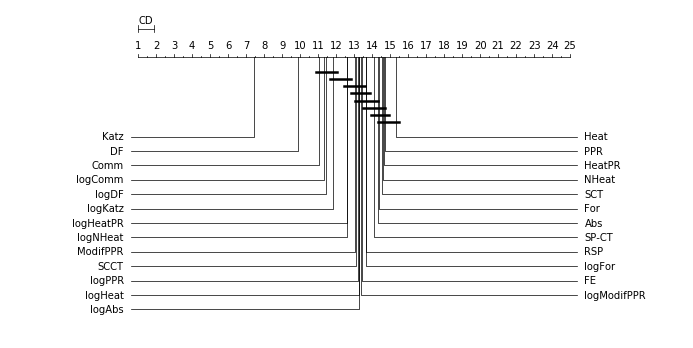

Partition 2, mari=0.42, n_experiments: 300
  (102, 3, 0.30, 0.150), (100, 4, 0.30, 0.100), (200, 4, 0.30, 0.150)


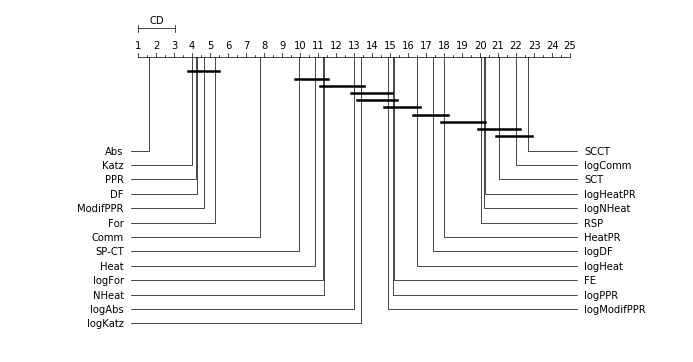

Partition 3, mari=0.73, n_experiments: 2200
  (100, 2, 0.10, 0.020), (100, 2, 0.10, 0.030), (100, 2, 0.15, 0.030), (100, 2, 0.15, 0.050), (100, 2, 0.15, 0.070), (100, 2, 0.20, 0.050), (100, 2, 0.20, 0.100), (100, 2, 0.30, 0.100), (100, 2, 0.30, 0.150), (102, 3, 0.10, 0.010), (102, 3, 0.10, 0.020), (102, 3, 0.30, 0.050), (102, 3, 0.30, 0.100), (100, 4, 0.10, 0.005), (100, 4, 0.10, 0.010), (100, 4, 0.10, 0.020), (150, 3, 0.10, 0.010), (150, 3, 0.10, 0.020), (200, 2, 0.30, 0.100), (200, 2, 0.30, 0.150), (201, 3, 0.30, 0.100), (200, 4, 0.30, 0.100)


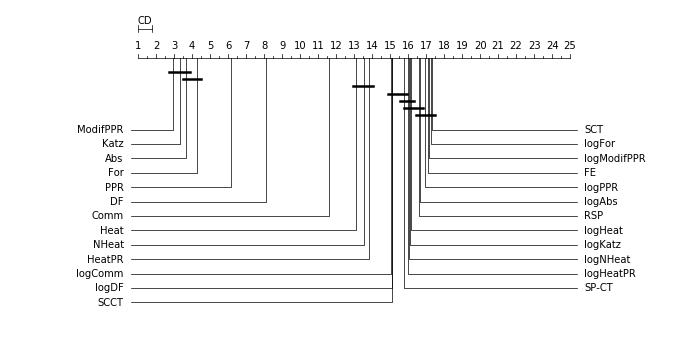

In [19]:
for group_idx, datasets_group in enumerate(datasets_partition):
    results_filtered = {k: v for k, v in results.items() if k[0] in datasets_group}
    results_modularity_any3 = defaultdict(lambda: defaultdict(list)) # {dataset_graphidx, {kernel_name: best_ari}}
    for (dataset, kernel_name, graph_idx), si_ari in results_filtered.items():
        results_modularity_any3[(dataset, graph_idx)][kernel_name] = si_ari['modularity_any3']

    avranks, names, n_experiments = calc_avranks(results_modularity_any3)
    
    print(f'Partition {group_idx}, mari={datasets_partition_mari[group_idx]:.2f}, n_experiments: {n_experiments}')
    print(f'  {", ".join(["(" + ", ".join(x.split("_")) + ")" for x in datasets_partition[group_idx]])}')
    cd = Orange.evaluation.compute_CD(avranks, n_experiments, alpha='0.1')
    Orange.evaluation.graph_ranks(avranks, names, cd=cd, width=9, textspace=1.5)
    plt.show()

# SBM neighbour score

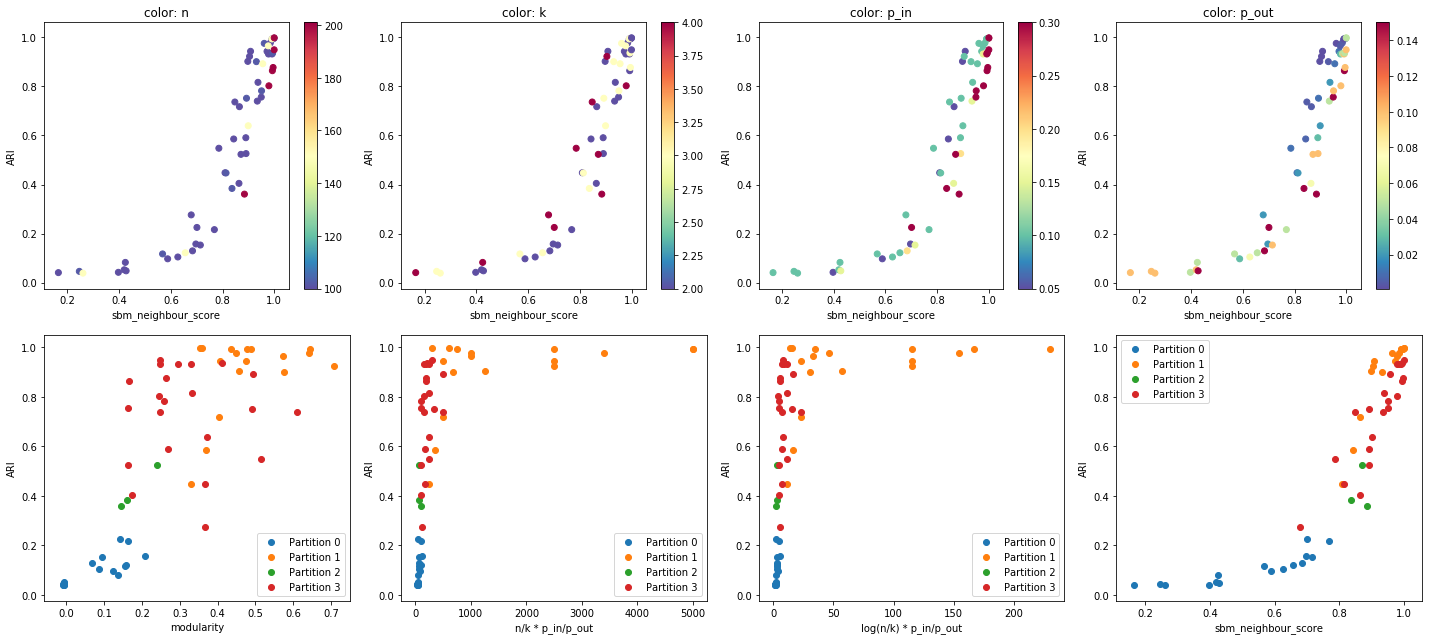

In [20]:
# draw ari-modularity dependency
fig, ax = plt.subplots(2, 4, figsize=(20, 9))
ax = np.ravel(ax)

for idx, feature in enumerate(['n', 'k', 'p_in', 'p_out']):
    x, y, v = [], [], []
    for dataset in datasets:
        x.append(extract_feature(dataset, 'sbm_neighbour_score'))
        y.append(dataset_meanari[dataset])
        v.append(extract_feature(dataset, feature))
    sc = ax[idx].scatter(x, y, c=v, cmap='Spectral_r')
    ax[idx].set_xlabel('sbm_neighbour_score')
    ax[idx].set_ylabel('ARI')
    ax[idx].set_title('color: ' + feature)
    plt.colorbar(sc, ax=ax[idx])

idx = 4
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(dataset_modularity[dataset])
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('modularity')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx = 5
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(extract_feature(dataset, 'n/k * p_in/p_out'))
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('n/k * p_in/p_out')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx = 6
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(extract_feature(dataset, 'log(n/k) * p_in/p_out'))
        y.append(dataset_meanari[dataset])
    sc = ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('log(n/k) * p_in/p_out')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=4)

idx = 7
for class_idx in range(n_clusters):
    datasetss = datasets_partition[class_idx]
    x, y = [], []
    for dataset in datasetss:
        x.append(extract_feature(dataset, 'sbm_neighbour_score'))
        y.append(dataset_meanari[dataset])
    ax[idx].scatter(x, y, label=f'Partition {class_idx}')
ax[idx].set_xlabel('sbm_neighbour_score')
ax[idx].set_ylabel('ARI')
ax[idx].legend(loc=2)

plt.tight_layout()